# Caracterización del comportamiento de vientos para energía eólica


### Resumen

Durante el siguiente código se presentara la caracterización de un grupo de medidas de velocidad de vientos cuyo origen no puede ser revelado. Esto se va a realizar a traves de una función de Weibull. La caracterización se realizara de dos formas, la primera es a traves de un método de regresión lineal y la segunda a tráves del método de máxima verisimilitud. Para esto se solucionara un sistema de ecuaciones no lineales y se realizara una regresión lineal de dos variables


#### Explicación método 1 : Regresión lineal

La función de densidad de probabilidad acumulativa de la distribución de weibull se puede expresar como:

$$F(x) = 1 - \exp(-(\frac{x}{\beta})^\alpha)$$

Acá alpha y beta son parámetros de la ecuación que se desean encontrar. A continuación se mostraran las transformaciones realizadas para expresar alpha y beta como productos de una regresión lineal.

$$F(x) = 1 - \exp(-(\frac{x}{\beta})^\alpha)$$
$$1 - F(x) = \exp(-(\frac{x}{\beta})^\alpha)$$
$$ \ln (1- F(x)) =  \ln(\exp(-(\frac{x}{\beta})^\alpha)) = -(\frac{x}{\beta})^\alpha)$$
$$ \ln(-\ln (1- F(x))) = \alpha * \ln (x) - \alpha * \ln(\beta) $$

Si se reemplaza $\ln(-\ln (1- F(x)))$ por $y_2$ y $\ln (x)$ por $x_2$, se obtiene la forma

$$y_2 = \alpha x_2 - \alpha * \ln(\beta)$$

Esto implica que al realizar una regresión lineal de la siguiente forma, se podrán obtener los parámetros alpha y beta a partir de las siguientes ecuaciones.

$$y_2 = m x_2 + b$$
$$\alpha = m$$
$$\beta = \exp{-\frac{b}{m}}$$

#### Explicación método 2 : Máxima verisimilitud

$$L = \prod_{i=0}^n f(x_i)$$
$$\frac{\partial L}{\partial \alpha} = 0 \rightarrow N = \sum_{i=0}^n \frac{x_i^\alpha}{\beta^\alpha}$$
$$\frac{\partial L}{\partial \beta} = 0 \rightarrow N = \alpha \sum_{i=0}^n \Big ( ln (x_i) * (\frac{x_i^\alpha}{\beta^\alpha}-1) \Big)$$ 
#### Librerias usadas
|Libreria|Uso|
|---|---|
|Pandas|Importación y manejo de las bases de datos|
|Numpy |representación de las funciones de densidad de probabilidad|
|Matplotlib| Gráficación de los resultados|
|Scipy|Regresión lineal y solución de sistemas de ecuaciones no lineales|
|Openpyxl|Lectura de nombres de un archivo excel|

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import scipy.stats as reg
import scipy.integrate as integ
from openpyxl import load_workbook

nombre_archivo = "Datos Viento-Tarea 3 headers3.xlsx"

#Inicialmente se importan todos los meses.

wb = load_workbook(nombre_archivo, read_only=True, keep_links=False) # Abre el archivo excel para conocer los nombres de las hojas
nombresMeses = wb.sheetnames # Extrae los nombres de las hojas a un array
datosMes=[] # Este array va a tener una base de datos para cada mes. Esto se hace para poder iterar procesos sobre cada mes.
for nombre_mes in nombresMeses:
    datosMes.append(pd.read_excel(nombre_archivo,sheet_name=nombre_mes,header = 0)) # Acá se importa la base de datos asociada a cada mes en el archivo excel como dataframe de pandas.
    print(nombre_mes) #Acá se imprime el mes y las dos primeras filas de cada base de datos para comprobar que la importación de datos se realizo de forma adecuada
    print(datosMes[-1][:2])


FEBRERO
    AÑO  MES  DIA  HORA  MIN  vel50  vel20  direccion   temp
0  2005    2    1     0    0   7.52  6.458       84.6  29.33
1  2005    2    1     0   10   7.38  6.232       84.6  29.37
OCTUBRE
    AÑO  MES  DIA  HORA  MIN  vel50  vel20  direccion   temp
0  2005   10    1     0    0  3.474  2.776      151.7  32.00
1  2005   10    1     0   10  3.402  2.609      149.6  31.64
MARZO
    AÑO  MES  DIA  HORA  MIN  vel50  vel20  direccion   temp
0  2005    3    1     0    0   8.48   7.57       99.0  30.39
1  2005    3    1     0   10   7.27   6.54       96.7  30.31


## Generación de las variables necesarias para los métodos de caracterización
* se parten estos datos utilizando la regla $\sqrt{n}= n_{bins}$
* El resultado de esto es un array de los 3 meses organizado de la siguiente forma => [Nombre del mes,DataFrame Partido] el dataFrame tendra frecuencia del intervalo
* Acá se utiliza un numero mayor de bins para octubre, pues los outliers llevan a que el uso de intervalos de tamaño uniforme no capturen adecuadamente el fenómeno.
* Cada elemento de datos partidos tiene la siguiente información :
    1. función de densidad de probabilidad discreta
    2. función de densidad de probabilidad acumulada discreta
    3. velocidad promedio para cada intervalo o bin de la función de probabilidad.
    4. la variable anteriormente descrita como $y_2$
    5. la variable anteriormente descrita como $x_2$

In [10]:
datosPartidos=[]
for i in range(len(datosMes)):
    m = datosMes[i] # data frame correspondiente al mes actual
    # acá se generan al intervalo y se le asigna a cada dato una nueva columna con el interavlo al que pertenece
    n=round(1+math.log2(len(m))) #Cantidad de intervalos
    if (nombresMeses[i]=="OCTUBRE"): # condicional para el mes de octubre.
        n=n*2
    std=np.std(m.vel50) # desviación estandar de la velocidad a 50 metros de altura
    prm=np.mean(m.vel50) # promedio de la velocidad a 50 metros de altura
    m["intervaloVel"]=pd.cut(m.vel50,bins=n) # generación de una columna dentro del array del mes que indica a que intervalo pertenece cada dato
    # acá se agrupa a partir de estos intervalos, se mantiene el nombre del mes en la primera posición del array para poder trabajar solo con una columna de datos
    f=m.groupby(['intervaloVel']).count().vel50.values/len(m) # generación de la función de densidad de probabilidad de las velocidades del viento a traves del mes.
    F=f.cumsum() # generación de la función de densidad de probabilidad acumulativa de las velocidades del viento a traves del mes.
    vprom=m.groupby(['intervaloVel']).mean().vel50.values # velocidad promedio para cada intervalo.
    yWeibull=np.log(-np.log(1-F[0:len(vprom)-1])) #Acá se elimina el ultima dato, pues se considera un outlier
    yWeibull=np.append(yWeibull,np.NaN) # acá se coloca un NaN donde estaría el último dato
    logv=np.log(vprom) 
    datosPartidos.append([nombresMeses[i],pd.DataFrame(data={"f":f,"F":F,"vprom":vprom,"yWeibull":yWeibull,"logv":logv})])

## Cálculo de los coeficientes según el método 1, máxima verosimilitud.
Para la solución de estas ecuaciones se usa la función fsolve de la libreria optimize de scipy. El objetivo de este método es llevar la salida de una función a 0. Para la solución de este problema se usara la siguiente función:

$$F\bigg (\begin{bmatrix}\alpha \\ \beta\end{bmatrix} \bigg) = \begin{bmatrix} n - \sum_{i=0}^n \frac{x_i^\alpha}{\beta^\alpha} \\ \alpha \sum_{i=0}^n \Big ( ln (x_i) * (\frac{x_i^\alpha}{\beta^\alpha}-1) - n \end{bmatrix} $$

De esta forma, si f llega a 0, se habrán cumplido ambas condiciones para el criterio de máxima verisimilitud

In [41]:
#Acá se calculan los parametros de maxima versimilitud a partir de la solución numerica del sistema de ecuaciones lineales.
nombres=[]
alphasMV=[]
betasMV=[]
for i in range(3):
    mesActual=i
    def sistemaEcuaciones(X): # Esta es la función referenciada arriba
        #X[0] = alpha
        #X[1] = beta
        eq1=0
        eq2=0
        baseActual=datosMes[mesActual]
        for i in range(len(baseActual)):
            eq1=eq1+np.power(baseActual.vel50.values[i],X[0])
            eq2=eq2+np.log(baseActual.vel50.values[i])*(np.power(baseActual.vel50.values[i],X[0])/np.power(X[1],X[0])-1)
        eq1=eq1/np.power(X[1],X[0])-len(baseActual)
        eq2=eq2*X[0]-len(baseActual)
        return [eq1,eq2]

    respuesta=opt.fsolve(sistemaEcuaciones,[4,4],xtol = 1e-7) # solución del sistema de ecuaciones con la solución inicial alpha = 4, beta = 4
    nombres.append(datosPartidos[i][0]) 
    alphasMV.append(round(respuesta[0],2))
    betasMV.append(round(respuesta[1],2))
respuestaFinal=pd.DataFrame(data={"Mes":nombres,"alpha por maxima verisimulitud":alphasMV,"beta por maxima verisimilitud":betasMV})

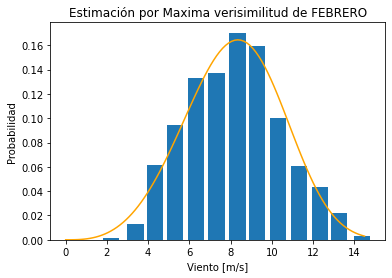

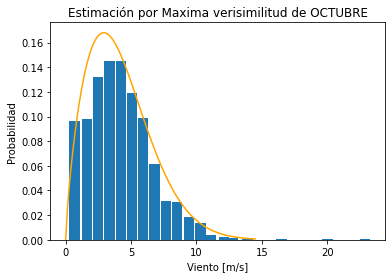

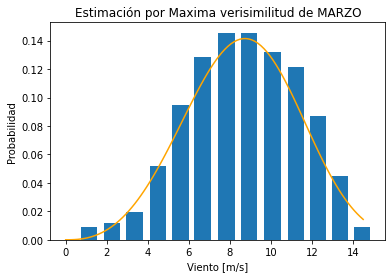

In [43]:
#Gráficación de los resultados
for i in range(3):
    beta=alphasMV[i] # esta variable es equivalente al beta en la función de distribución de probabilidad
    alpha=betasMV[i] #esta variable es equivalente al eta en la función de distribución de probabilidad
    vprom=datosPartidos[i][1].vprom.values
    valorMaximoAGraficar=np.max(np.max(vprom))*0+14
    xreg=np.linspace(0,14.5,100)
    plt.bar(height=datosPartidos[i][1].f.values,x=datosPartidos[i][1].vprom.values)
    y =[]
    for j in range(len(xreg)):
        y.append(beta/alpha*np.power((xreg[j]/alpha),(beta-1)) * np.exp(-np.power(xreg[j]/alpha,beta)))
    plt.plot(xreg, y,color="orange")
    plt.xlabel('Viento [m/s]')
    plt.ylabel('Probabilidad')
    plt.title("Estimación por Maxima verisimilitud de "+datosPartidos[i][0])
    plt.show()
    plt.close()

## Cálculo de los coeficientes según el método 2, regresión lineal.

LinregressResult(slope=3.562693844460855, intercept=-7.6111842297784085, rvalue=0.9993239410667213, pvalue=2.2816967359599547e-08, stderr=0.05861666024749029, intercept_stderr=0.12324106316936054)


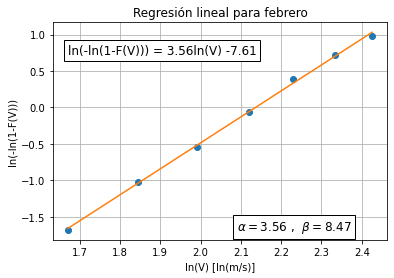

LinregressResult(slope=1.6539835303397497, intercept=-2.393975703442057, rvalue=0.9991936011320777, pvalue=1.8482357879325955e-12, stderr=0.023498434197956285, intercept_stderr=0.03922616580388151)


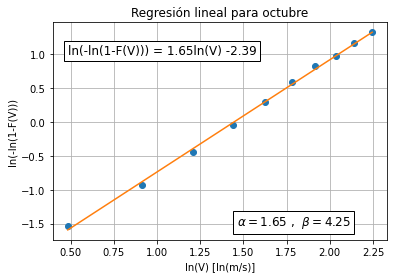

LinregressResult(slope=3.18286660692096, intercept=-7.0384877738902105, rvalue=0.9997729414670494, pvalue=7.732751301161764e-08, stderr=0.0339192562792176, intercept_stderr=0.07166036958011567)


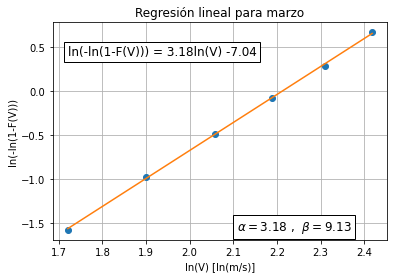

In [44]:
#Acá se realizara el metodo de regresión lineal a los logaritmos.
alphasreglin=[]
betasreglin=[]
for i in range(3):
    prueba=datosPartidos[i][1]
    #Acá se eliminan los extremos de los datos
    corteMin=min(min(np.where(prueba.F.values>0.1))) # corte min es el menor intervalo cuya función de densidad de probabilidad es mayor a 0.1
    corteMax=max(max(np.where(prueba.F.values<0.99))) # corte max es el mayor intervalo cuya función de densidad de probabilidad es menor a 0.9
    x=prueba.logv.values[corteMin:corteMax]
    y=prueba.yWeibull.values[corteMin:corteMax]
    #Acá se realiza la regresión lineal
    print(reg.linregress(x,y))
    m,b,r2,pv,std=reg.linregress(x,y)
    alpha=m
    beta=np.exp(-b/m)
    alphasreglin.append(round(alpha,2)) 
    betasreglin.append(round(beta,2))
    
    xreglin=np.linspace(x[0],x[-1],10)
    yreglin=xreglin*m+b
    #Acá se realiza la gráfica
    plt.plot(x,y,marker="o",linewidth=0)
    #Las dos siguientes lineas son las anotaciones.
    plt.text(xreglin[0], yreglin[-2], 'ln(-ln(1-F(V))) = '+str(round(alpha,2))+"ln(V) "+str(round(b,2)),fontsize=12,bbox=dict(dict(boxstyle="square",ec=(0, 0, 0),fc=(1, 1, 1),)))
    plt.text(xreglin[5], y[0], r'$\alpha =$'+str(round(alpha,2))+" ,  "+r'$\beta =$'+str(round(beta,2)),fontsize=12,bbox=dict(dict(boxstyle="square",ec=(0, 0, 0),fc=(1, 1, 1),)))
    plt.plot(xreglin,yreglin)
    plt.grid(True)
    plt.ylabel("ln(-ln(1-F(V)))")
    plt.xlabel("ln(V) [ln(m/s)]")
    plt.title("Regresión lineal para "+datosPartidos[i][0].lower())
    plt.show()
    plt.close()

alpha :8.47  beta :3.56


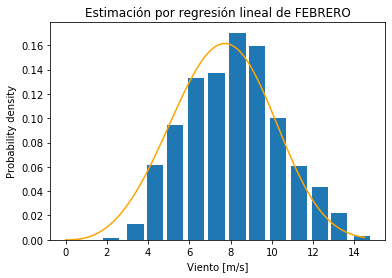

alpha :4.25  beta :1.65


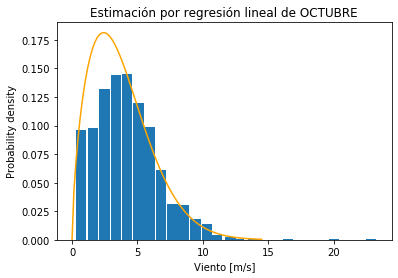

alpha :9.13  beta :3.18


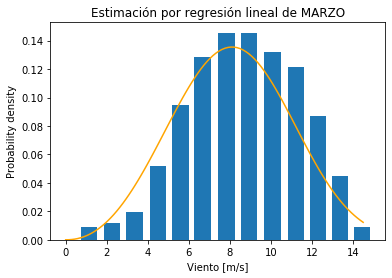

In [32]:
#acá se gráfican los estimados a partir de la regresión lineal.
for i in range(3):
    beta=alphasreglin[i] # esta variable es equivalente al beta en la función de distribución de probabilidad
    alpha=betasreglin[i] #esta variable es equivalente al eta en la función de distribución de probabilidad
    print("alpha :"+str(alpha)+"  beta :"+str(beta))
    vprom=datosPartidos[i][1].vprom.values
    valorMaximoAGraficar=np.max(np.max(vprom))*0+14
    xreg=np.linspace(0,14.5,100)
    plt.bar(height=datosPartidos[i][1].f.values,x=datosPartidos[i][1].vprom.values)
    y =[]
    for j in range(len(xreg)):
        y.append(beta/alpha*np.power((xreg[j]/alpha),(beta-1)) * np.exp(-np.power(xreg[j]/alpha,beta)))
    plt.plot(xreg, y,color="orange")
    plt.xlabel('Viento [m/s]')
    plt.ylabel('Probability density')
    plt.title("Estimación por regresión lineal de "+datosPartidos[i][0])
    plt.show()
    plt.close()

In [30]:
respuestaFinal["alpha por regresión"]=alphasreglin
respuestaFinal["beta por regresión"]=betasreglin
respuestaFinal

,Mes,alpha por maxima verisimulitud,beta por maxima verisimilitud,alpha por regresión,beta por regresión
0,FEBRERO,3.89,9.02,3.56,8.47
1,OCTUBRE,1.75,4.72,1.65,4.25
2,MARZO,3.53,9.60,3.18,9.13


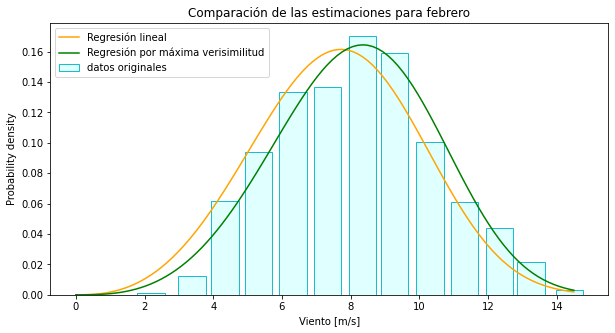

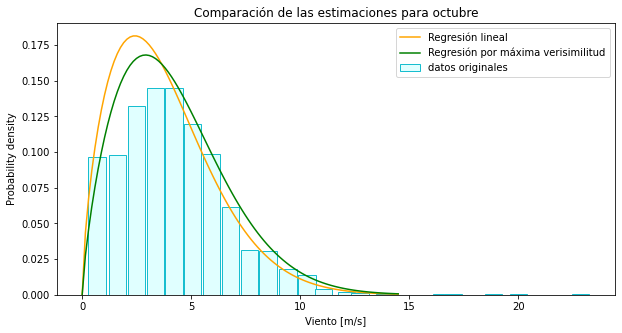

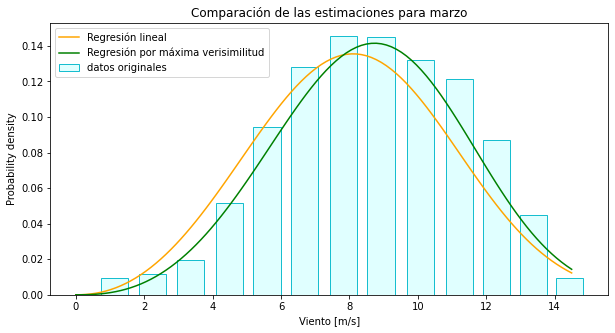

In [45]:
#Acá se comparan las regresiones.
for  i in range(3):
    plt.figure(figsize = (10,5))
    beta=alphasreglin[i] # esta variable es equivalente al beta en la función de distribución de probabilidad
    alpha=betasreglin[i] #esta variable es equivalente al eta en la función de distribución de probabilidad
    vprom=datosPartidos[i][1].vprom.values
    valorMaximoAGraficar=np.max(np.max(vprom))*0+14
    xreg=np.linspace(0,14.5,100)
    plt.bar(height=datosPartidos[i][1].f.values,x=datosPartidos[i][1].vprom.values,edgecolor = "tab:cyan",color = "lightcyan",label = "datos originales")
    y =[]
    for j in range(len(xreg)):
        y.append(beta/alpha*np.power((xreg[j]/alpha),(beta-1)) * np.exp(-np.power(xreg[j]/alpha,beta)))

    beta=alphasMV[i] # esta variable es equivalente al beta en la función de distribución de probabilidad
    alpha=betasMV[i] #esta variable es equivalente al eta en la función de distribución de probabilidad
    y2 = []
    for j in range(len(xreg)):
        y2.append(beta/alpha*np.power((xreg[j]/alpha),(beta-1)) * np.exp(-np.power(xreg[j]/alpha,beta)))
    plt.plot(xreg, y,label = "Regresión lineal",color = "orange")
    plt.plot(xreg, y2,label = "Regresión por máxima verisimilitud",color = "green")
    plt.xlabel('Viento [m/s]')
    plt.ylabel('Probability density')
    plt.title("Comparación de las estimaciones para "+nombresMeses[i].lower())
    plt.legend()
    plt.show()
    plt.close()